# Versions

v1 pairwise

v2 ndcg

v3 map

v4 pairwise,w_rank

v5 pairwise,SVER2

v6 ndcg,SVER2

v7 map,SVER2

v8 pairwise,SVER3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
VER = 8
SVER = 3
IVER = 1
UVER = 1
WVER = 1
FEATURES = [
        'user', 'item_item_count', 'item_user_count', 
        'item_buy_ratio', 'user_user_count', 'user_item_count',
        'user_buy_ratio']

In [ ]:
!nvidia-smi

Thu Jan 26 02:40:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd, numpy as np
import pickle, glob, gc
from collections import Counter
import itertools
# multiprocessing 
import psutil
from multiprocessing import Pool
from sklearn.model_selection import GroupKFold
import psutil
import random
import os
N_CORES = psutil.cpu_count()     # Available CPU cores
print(f"N Cores : {N_CORES}")
from multiprocessing import Pool
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(42)

N Cores : 12


In [ ]:
def merge_candidate(SVER,IVER,UVER,WVER,TYPE,MODE):
    candidates = pd.read_parquet(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/candidate/suggest/{TYPE}/{MODE}_{TYPE}{SVER}.pqt')
    candidates['session'] = candidates.index
    candidates = candidates.set_index('session')
    item_features = pd.read_parquet(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/candidate/item/{MODE}_item{IVER}.pqt')
    candidates = candidates.merge(item_features, left_on='item', right_index=True, how='left').fillna(-1)
    user_features = pd.read_parquet(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/candidate/user/{MODE}_user{UVER}.pqt')
    candidates = candidates.merge(user_features, left_on='session', right_index=True, how='left').fillna(-1)
    candidates['user'] = candidates.index
    candidates = candidates.set_index('user')
    return candidates

In [ ]:
def merge_target(TYPE,candidates):
    tar = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/otto-validation/test_labels.parquet')
    tar = tar.loc[ tar['type']==TYPE ]
    aids = tar.ground_truth.explode().astype('int32').rename('item')
    tar = tar[['session']].astype('int32').rename({'session':'user'},axis=1)
    tar = tar.merge(aids, left_index=True, right_index=True, how='left')
    tar[TYPE] = 1
    candidates = candidates.merge(tar,on=['user','item'],how='left').fillna(0)
    return candidates

In [ ]:
!pip install -q xgboost==1.6.2
import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import recall_score

In [ ]:
def train_xgb(candidates,TARGET):
    preds = np.zeros(len(candidates))
    skf = GroupKFold(n_splits=5)
    for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates[TARGET], groups=candidates['user'] )):

        X_train = candidates.loc[train_idx, FEATURES]
        y_train = candidates.loc[train_idx, TARGET]
        X_valid = candidates.loc[valid_idx, FEATURES]
        y_valid = candidates.loc[valid_idx, TARGET]

        X_train = X_train.sort_values("user").reset_index(drop=True)
        X_valid = X_valid.sort_values("user").reset_index(drop=True)

        train_group = X_train.groupby('user').user.agg('count').values
        valid_group = X_valid.groupby('user').user.agg('count').values

        X_train = X_train.drop(["user"], axis=1)
        X_valid = X_valid.drop(["user"], axis=1)

        dtrain = xgb.DMatrix(X_train, y_train,group=train_group)
        dvalid = xgb.DMatrix(X_valid, y_valid,group=valid_group)

        xgb_parms = {
            'objective':'rank:pairwise', 
            'tree_method':'gpu_hist',
            'random_state': 42, 
            'learning_rate': 0.1,
            "colsample_bytree": 0.8, 
            'max_depth': 6,
        }
        model = xgb.train(xgb_parms, 
            dtrain=dtrain,
            evals=[(dtrain,'train'),(dvalid,'valid')],
            num_boost_round=1000,
            verbose_eval=500)
        preds[valid_idx] = model.predict(dvalid)
        model.save_model(f'XGB_fold{fold}_{TARGET}.xgb')
    predictions = candidates[['user','item']].copy()
    predictions['pred'] = preds
    predictions = predictions.sort_values(['user','pred'], ascending=[True,False]).reset_index(drop=True)
    predictions['n'] = predictions.groupby('user').item.cumcount().astype('int8')
    predictions = predictions.loc[predictions.n<20]
    sub = predictions.groupby('user').item.apply(list)
    sub = sub.to_frame().reset_index()
    sub.item = sub.item.apply(lambda x: " ".join(map(str,x)))
    sub.columns = ['session','labels']
    sub.labels = sub.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])
    test_labels = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/otto-validation/test_labels.parquet')
    test_labels = test_labels.loc[test_labels['type']==TARGET]
    test_labels = test_labels.merge(sub, how='left', on=['session'])
    test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
    test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
    recall = test_labels['hits'].sum() / test_labels['gt_count'].sum()
    print('{} Recall = {:.5f}'.format(TARGET,recall))

# validation

## clicks

In [ ]:
%%time
candidates = merge_candidate(SVER,IVER,UVER,WVER,'clicks','val')
candidates = merge_target('clicks',candidates)
train_xgb(candidates,'clicks')
del candidates
_ = gc.collect()

[0]	train-map:0.60887	valid-map:0.60744
[500]	train-map:0.50815	valid-map:0.50402
[999]	train-map:0.51152	valid-map:0.50515
[0]	train-map:0.56557	valid-map:0.56586
[500]	train-map:0.50856	valid-map:0.50512
[999]	train-map:0.51189	valid-map:0.50619
[0]	train-map:0.59683	valid-map:0.59565
[500]	train-map:0.50869	valid-map:0.50350
[999]	train-map:0.51197	valid-map:0.50450
[0]	train-map:0.60209	valid-map:0.60177
[500]	train-map:0.50860	valid-map:0.50548
[999]	train-map:0.51177	valid-map:0.50639
[0]	train-map:0.56909	valid-map:0.56899
[500]	train-map:0.50848	valid-map:0.50524
[999]	train-map:0.51169	valid-map:0.50647
clicks Recall = 0.33351
CPU times: user 18min 28s, sys: 20.8 s, total: 18min 49s
Wall time: 15min 30s


## carts

In [ ]:
%%time
candidates = merge_candidate(SVER,IVER,UVER,WVER,'carts','val')
candidates = merge_target('carts',candidates)
train_xgb(candidates,'carts')
del candidates
_ = gc.collect()

[0]	train-map:0.92298	valid-map:0.92323
[500]	train-map:0.90110	valid-map:0.89827
[999]	train-map:0.90283	valid-map:0.89840
[0]	train-map:0.92097	valid-map:0.92082
[500]	train-map:0.90110	valid-map:0.89812
[999]	train-map:0.90288	valid-map:0.89822
[0]	train-map:0.92316	valid-map:0.92184
[500]	train-map:0.90128	valid-map:0.89724
[999]	train-map:0.90317	valid-map:0.89731
[0]	train-map:0.92275	valid-map:0.92307
[500]	train-map:0.90104	valid-map:0.89826
[999]	train-map:0.90292	valid-map:0.89842
[0]	train-map:0.91364	valid-map:0.91433
[500]	train-map:0.90084	valid-map:0.89889
[999]	train-map:0.90265	valid-map:0.89892
carts Recall = 0.25190
CPU times: user 15min 44s, sys: 6.06 s, total: 15min 50s
Wall time: 14min 19s


## orders

In [ ]:
%%time
candidates = merge_candidate(SVER,IVER,UVER,WVER,'orders','val')
candidates = merge_target('orders',candidates)
train_xgb(candidates,'orders')
del candidates
_ = gc.collect()

[0]	train-map:0.94674	valid-map:0.94641
[500]	train-map:0.94031	valid-map:0.93783
[999]	train-map:0.94182	valid-map:0.93785
[0]	train-map:0.94681	valid-map:0.94618
[500]	train-map:0.94066	valid-map:0.93703
[999]	train-map:0.94206	valid-map:0.93708
[0]	train-map:0.94811	valid-map:0.94755
[500]	train-map:0.94047	valid-map:0.93754
[999]	train-map:0.94191	valid-map:0.93755
[0]	train-map:0.94906	valid-map:0.94903
[500]	train-map:0.94047	valid-map:0.93783
[999]	train-map:0.94192	valid-map:0.93779
[0]	train-map:0.94537	valid-map:0.94568
[500]	train-map:0.94033	valid-map:0.93827
[999]	train-map:0.94174	valid-map:0.93820
orders Recall = 0.37112
CPU times: user 15min 43s, sys: 5.88 s, total: 15min 49s
Wall time: 14min 19s


# inference

In [ ]:
def predict(test_candidates,TYPE):
    preds = np.zeros(len(test_candidates))
    test_candidates.reset_index(inplace=True)
    for fold in range(5):
        model = xgb.Booster()
        model.load_model(f'XGB_fold{fold}_{TYPE}.xgb')
        model.set_param({'predictor': 'gpu_predictor'})
        dtest = xgb.DMatrix(data=test_candidates[FEATURES].drop(["user"], axis=1))
        preds += model.predict(dtest)/5
    predictions = test_candidates[['user','item']].copy()
    predictions['pred'] = preds
    predictions = predictions.sort_values(['user','pred'], ascending=[True,False]).reset_index(drop=True)
    predictions['n'] = predictions.groupby('user').item.cumcount().astype('int8')
    predictions = predictions.loc[predictions.n<20]
    sub = predictions.groupby('user').item.apply(list)
    sub = sub.to_frame().reset_index()
    sub.item = sub.item.apply(lambda x: " ".join(map(str,x)))
    sub.columns = ['session_type','labels']
    sub.session_type = sub.session_type.astype('str')+ f'_{TYPE}'
    return sub

## clicks

In [ ]:
%%time
test_candidates = merge_candidate(SVER,IVER,UVER,WVER,'clicks','test')
clicks_pred_df = predict(test_candidates,'clicks')
del test_candidates
_ = gc.collect()

CPU times: user 3min 53s, sys: 3.42 s, total: 3min 56s
Wall time: 2min 50s


## carts

In [ ]:
%%time
test_candidates = merge_candidate(SVER,IVER,UVER,WVER,'carts','test')
carts_pred_df = predict(test_candidates,'carts')
del test_candidates
_ = gc.collect()

## orders

In [ ]:
%%time
test_candidates = merge_candidate(SVER,IVER,UVER,WVER,'orders','test')
orders_pred_df = predict(test_candidates,'orders')
del test_candidates
_ = gc.collect()

CPU times: user 3min 43s, sys: 3.34 s, total: 3min 46s
Wall time: 2min 46s


# submission

In [ ]:
pred_df = pd.concat([clicks_pred_df, orders_pred_df, carts_pred_df])
pred_df.columns = ["session_type", "labels"]
pred_df.to_csv(f"xgb{VER}.csv", index=False)
pred_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/submission/xgb{VER}.csv', index=False)

In [ ]:
!pip install kaggle -q
import os
import json
f = open("/content/drive/MyDrive/Colab Notebooks/kaggle/kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [ ]:
!kaggle competitions submit -c otto-recommender-system -f xgb8.csv -m ""

100% 778M/778M [00:14<00:00, 56.6MB/s]
Successfully submitted to OTTO – Multi-Objective Recommender System

In [ ]:
import matplotlib.pyplot as plt
model = xgb.Booster()
model.load_model(f'XGB_fold1_clicks.xgb')

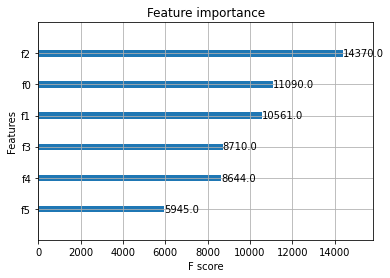

In [ ]:
xgb.plot_importance(model)
plt.show()

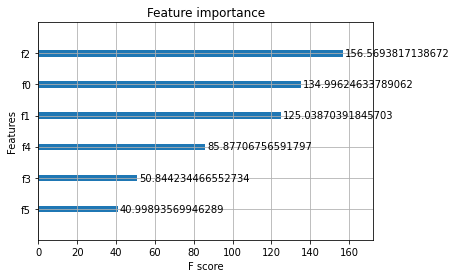

In [ ]:
xgb.plot_importance(model,importance_type='gain')
plt.show()